In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
import matplotlib.pyplot as plt 
from bliss.encoders.autoencoder import OneCenteredGalaxyAE
import torch
import numpy as np

In [ ]:
ae = OneCenteredGalaxyAE().eval()
ae.load_state_dict(torch.load("../../models/autoencoder_42.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
ds = torch.load("../../data/datasets/test_ae_ds_42_20240920164841.pt")

/tmp/ipykernel_3491797/4096256519.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ds = torch.load("../../data/datasets/test_ae_ds_42_20240920164841.pt")


In [ ]:
images = ds['images'].float()
noiseless = ds['noiseless'].float()
background = ds['background'].float()
images.shape, background.shape, noiseless.shape


(torch.Size([191968, 1, 53, 53]),
 torch.Size([191968, 1, 53, 53]),
 torch.Size([191968, 1, 53, 53]))

In [ ]:
from bliss.reporting import get_snr

snr = get_snr(noiseless,background)

(array([  279.,   590.,  1573.,  5797., 23798., 27685., 24065., 20307.,
        16849., 14256., 11731.,  9425.,  7618.,  6332.,  4867.,  4011.,
         3097.,  2359.,  1872.,  1473.,  1062.,   800.,   619.,   406.,
          271.]),
 array([0.        , 0.12      , 0.23999999, 0.36000001, 0.47999999,
        0.60000002, 0.72000003, 0.83999997, 0.95999998, 1.08000004,
        1.20000005, 1.32000005, 1.44000006, 1.55999994, 1.67999995,
        1.79999995, 1.91999996, 2.03999996, 2.16000009, 2.27999997,
        2.4000001 , 2.51999998, 2.6400001 , 2.75999999, 2.88000011,
        3.        ]),
 <BarContainer object of 25 artists>)

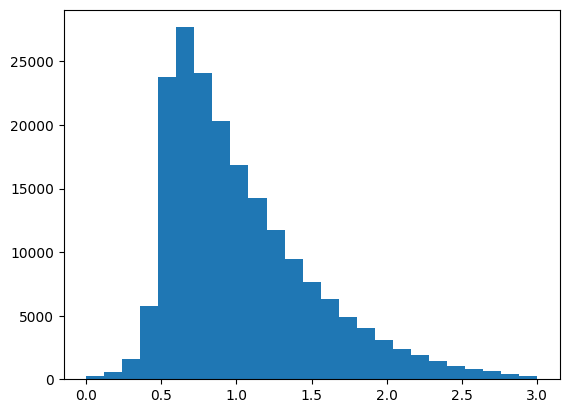

In [ ]:
# snr histogram looks fine
plt.hist(snr.log10(), bins=25, range=(0, 3))

In [ ]:
sum((snr.log10() > 2.9) & ( snr.log10() < 3.0))

tensor(236)

In [ ]:
mask = (snr > 5) & ( snr < 7)

test_im = images[mask]
bg  = background[mask]
nn = noiseless[mask]

sum(mask), test_im.shape

(tensor(29636), torch.Size([29636, 1, 53, 53]))

In [ ]:
with torch.no_grad():
    recon = ae.forward(test_im, bg)
recon.shape

torch.Size([29636, 1, 53, 53])

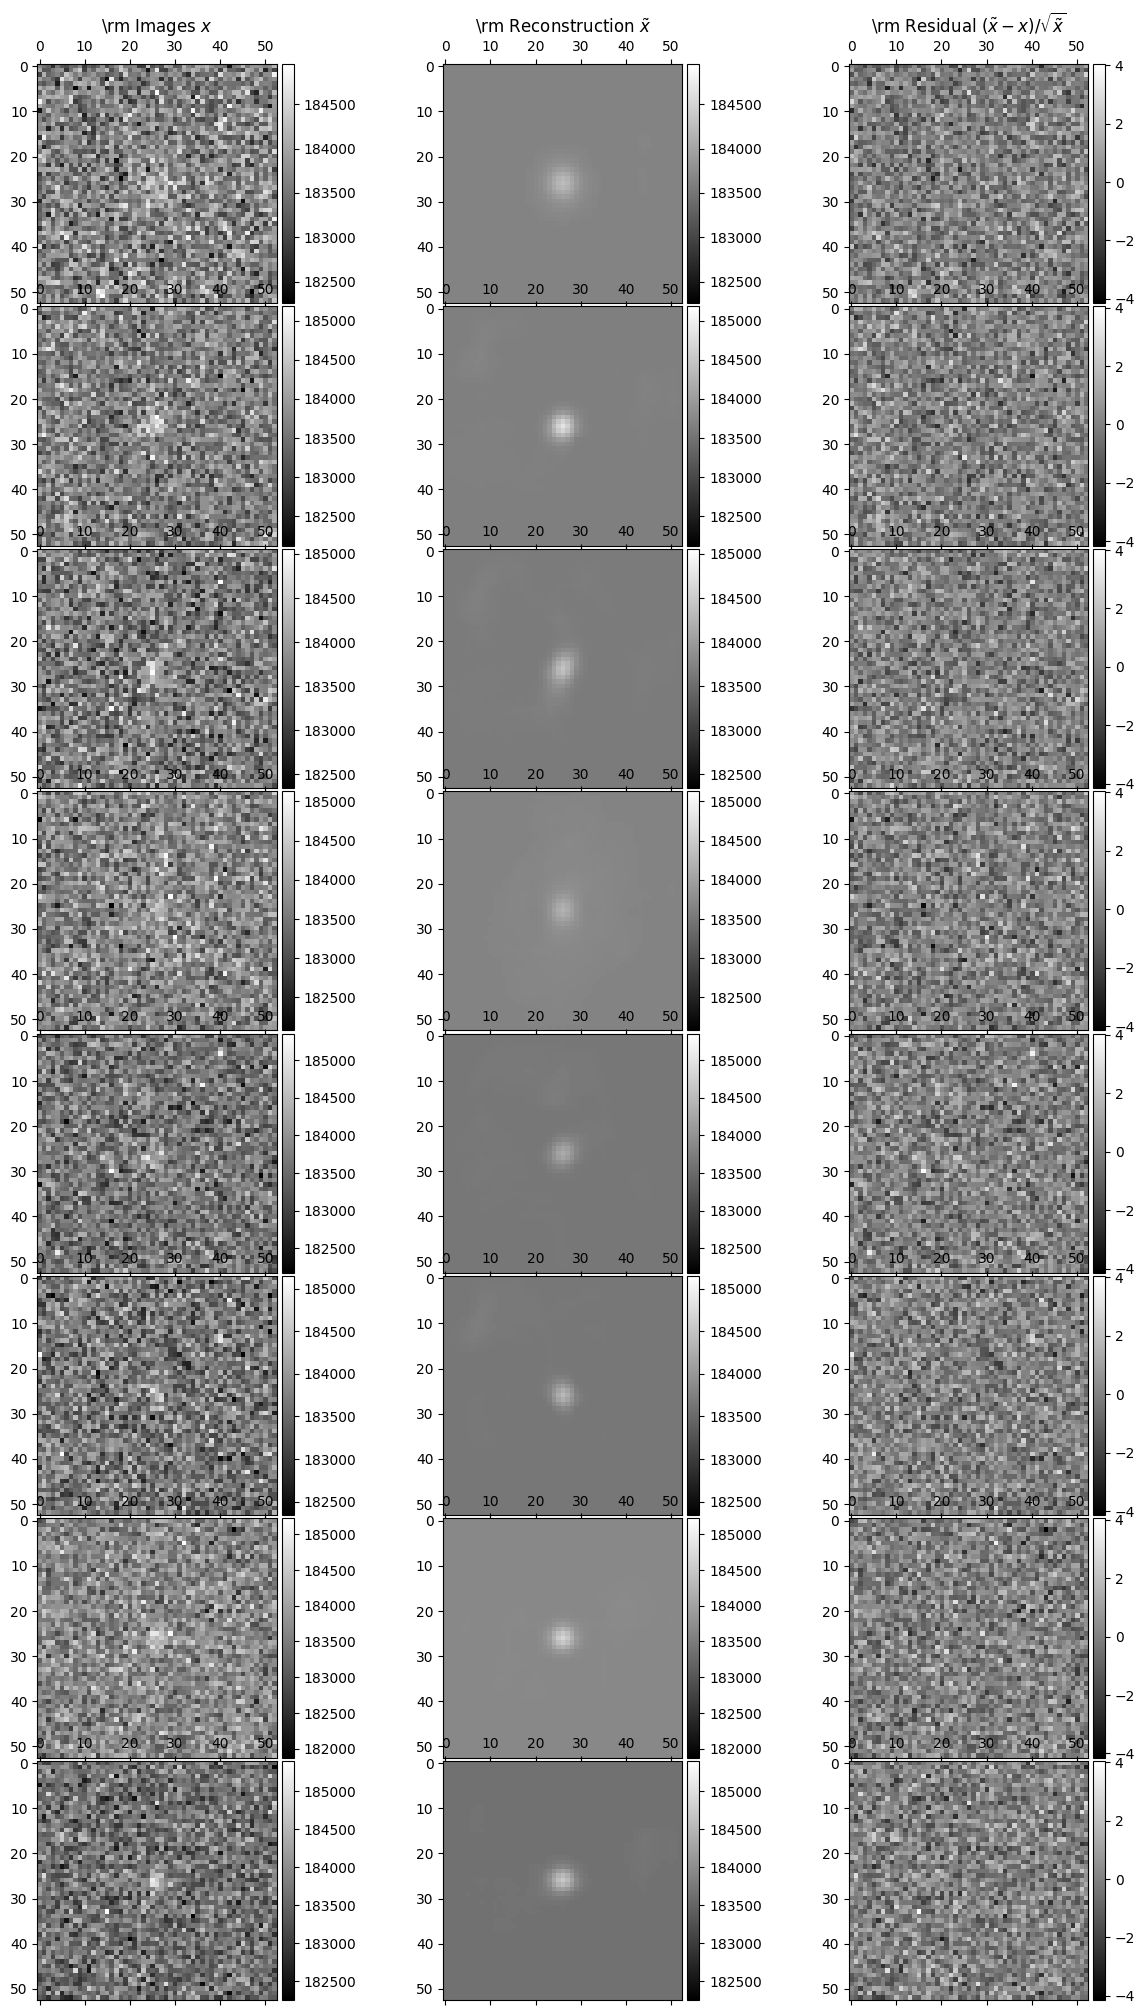

In [ ]:
from experiment.scripts_figures.ae_figures import _reconstruction_figure

indices = np.random.choice(np.arange(recon.shape[0]), size=8)
residuals = (test_im - recon) / recon.sqrt()
fig = _reconstruction_figure(8, test_im[indices], recon[indices], residuals[indices])


## Cached results

In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
results = torch.load("../../data/cache/ae.pt")

/tmp/ipykernel_3499396/3390019881.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load("../../data/cache/ae.pt")


In [ ]:
results.keys()

dict_keys(['random', 'worst', 'measurements'])

In [ ]:
snr = results['measurements']['snr']
snr.shape

torch.Size([191968])

In [ ]:
e1_t = results['measurements']['true_ellips'][:, 0]
e1_p = results['measurements']['recon_ellips'][:, 0]

e2_t = results['measurements']['true_ellips'][:, 1]
e2_p = results['measurements']['recon_ellips'][:, 1]
e1_t.shape

torch.Size([191968])

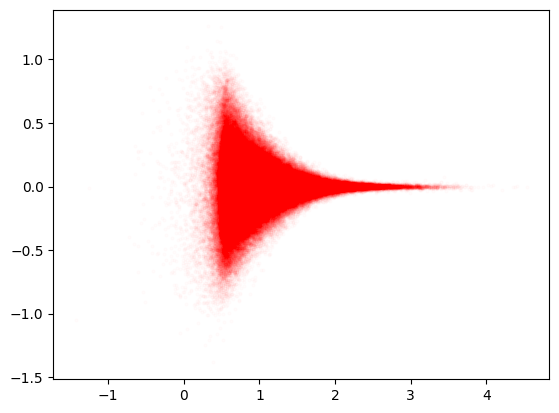

In [ ]:
plt.scatter(snr.log10(), e1_t - e1_p, s=5, color='r', alpha=0.01)

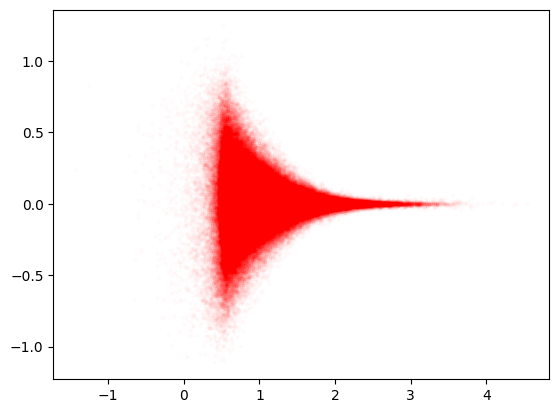

In [ ]:
plt.scatter(snr.log10(), e2_t - e2_p, s=5, color='r', alpha=0.01)

## aperture photometry (?)

In [ ]:
# aperture photometry comparison of flux 